## Loading Essential Libraries

In [1]:
# Libraries to help with reading and manipulating data
import numpy as np
import pandas as pd

# Libraries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Set pandas display options for better readability of output
from IPython.display import display
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 200)
pd.set_option("display.float_format", lambda x: "%.4f" % x)

# Set Seaborn aesthetic parameters
sns.set(
    context='notebook',
    style='darkgrid',
    font='sans-serif',
    font_scale=0.8,
    rc={'figure.figsize': (12, 6)}
)

# Set the color cycle for matplotlib to 'steelblue'
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=['steelblue'])

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Loading Dataset

In [3]:
# Loading Sales Data file and display top 5 rows
df_path = "/content/drive/MyDrive/Colab Notebooks/MRA/Project B/dataset_group.csv"
df_mba = pd.read_csv(df_path)
df_mba.head()

,Date,Order_id,Product
0,01-01-2018,1,yogurt
1,01-01-2018,1,pork
2,01-01-2018,1,sandwich bags
3,01-01-2018,1,lunch meat
4,01-01-2018,1,all- purpose


## Data Overview

In [4]:
# Display shape of the data
print(f'The dataset has {df_mba.shape[0]} rows and {df_mba.shape[1]} columns.')

The dataset has 20641 rows and 3 columns.


In [5]:
# Display dataset information
display(df_mba.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20641 entries, 0 to 20640
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Date      20641 non-null  object
 1   Order_id  20641 non-null  int64 
 2   Product   20641 non-null  object
dtypes: int64(1), object(2)
memory usage: 483.9+ KB


None

**Observations:**
* Dataset has 2 categorical, 1 numerical columns.
* Total memory usage is 483.9+ KB

In [6]:
# Dataset Statistics
# Describe numerical fields
numerical_columns = df_mba.select_dtypes(include=['number']).columns
numerical_description = df_mba[numerical_columns].describe().T

# Describe categorical fields
categorical_description = df_mba.select_dtypes(include=['object']).describe().T

# Display the descriptions
display(numerical_description, categorical_description)

,count,mean,std,min,25%,50%,75%,max
Order_id,20641.0000,575.9863,328.5571,1.0000,292.0000,581.0000,862.0000,1139.0000


,count,unique,top,freq
Date,20641,603,08-02-2019,183
Product,20641,37,poultry,640


In [7]:
# Display count of Unique Orders:
print(f"Total Order Count: {df_mba['Order_id'].nunique()}.")

Total Order Count: 1139.


In [8]:
# Display First and Last Date of Orders.
df_mba['Order_date'] = pd.to_datetime(df_mba['Date'], format="%d-%m-%Y")
print(f"First Order Date: {df_mba['Order_date'].min()}.")
print(f"Last Order Date: {df_mba['Order_date'].max()}.")

First Order Date: 2018-01-01 00:00:00.
Last Order Date: 2020-02-26 00:00:00.


**Observations**

* Dataset has 20,641 records and 3 columns.
* Records contain details about 1,139 orders.
* Grocery store has sold 37 products.
* Transactions span from Jan, 2018 till Feb, 2020.

In [9]:
# Check for missing values
df_mba.isnull().sum()

,0
Date,0
Order_id,0
Product,0
Order_date,0


**Observation**
* There are no missing values in the dataset.

In [10]:
# Check for Duplicates
df_mba.duplicated().sum()

4730

**Observation:**
* There are 4,730 duplicate records. We will drop them before proceeding with EDA.

In [11]:
# Remove Duplicate Values
df_mba_treated = df_mba.drop_duplicates()

In [12]:
# Check the Shape of the Dataset after removing Duplicates
df_mba_treated.shape

(15911, 4)

* Number of records reduced to 15,911.

In [13]:
# Write CSV file for Market Basket Analysis
df_mba_treated.to_csv('/content/drive/MyDrive/Colab Notebooks/MRA/Project B/mba_dataset_treated.csv', index=False)

## Exploratory Data Analysis

### Univariate Analysis

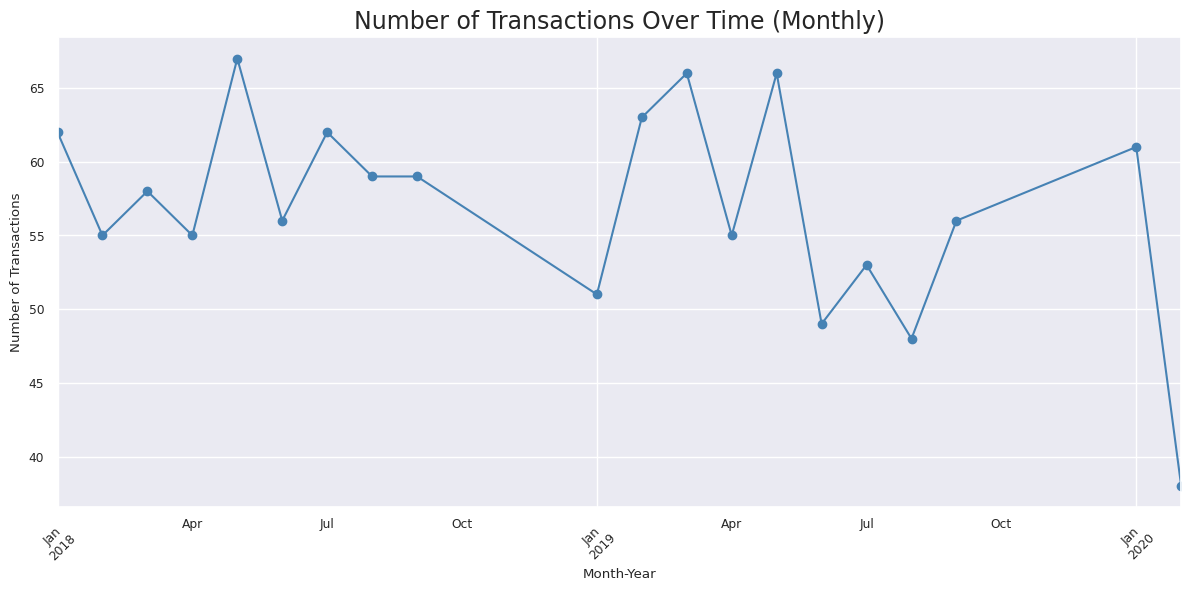

In [14]:
# Visualizing the number of transactions over time (monthly)
monthly_transactions = df_mba_treated.groupby(df_mba_treated['Order_date'].dt.to_period('M'))['Order_id'].nunique()

monthly_transactions.plot(kind='line', marker='o')
plt.title('Number of Transactions Over Time (Monthly)', fontsize=17)
plt.xlabel('Month-Year')
plt.ylabel('Number of Transactions')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Order Date Analysis:**

* The number of transactions shows a steady pattern with notable spikes during certain months, which could be indicative of seasonal promotions or holidays.
* There is a visible peak in transactions during May month, suggesting a potential increase in shopping activity during the period.
* The steady decline in transactions toward the end of the dataset might indicate either a data collection issue or a natural decrease in shopping activity.

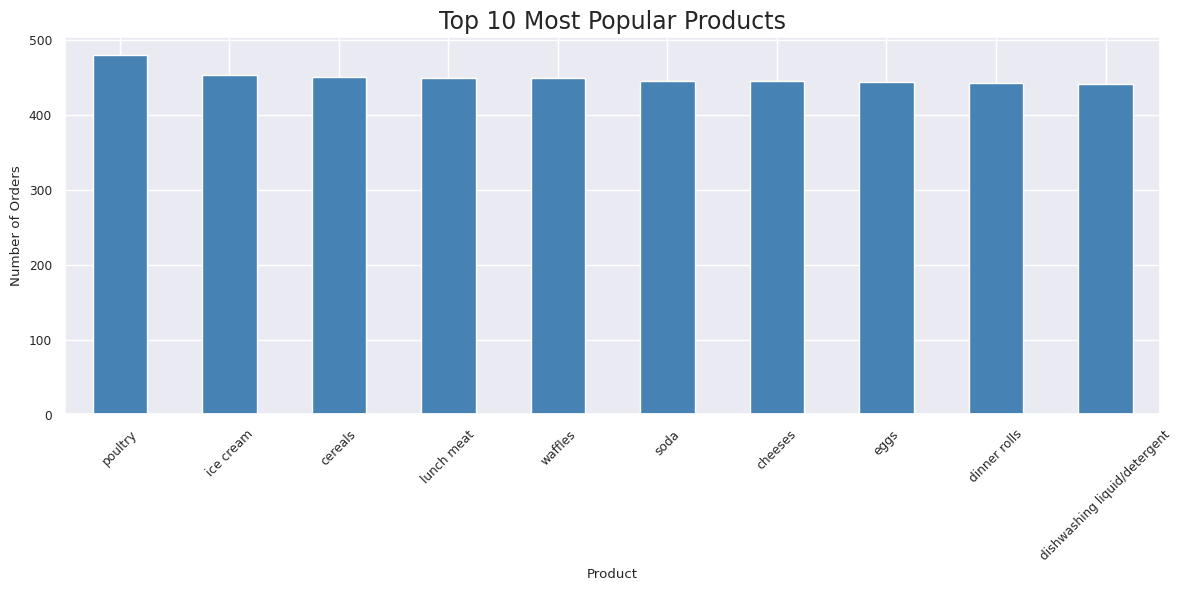

In [15]:
# Visualizing the top 10 most popular products
top_products = df_mba_treated['Product'].value_counts().head(10)

top_products.plot(kind='bar')
plt.title('Top 10 Most Popular Products', fontsize=17)
plt.xlabel('Product')
plt.ylabel('Number of Orders')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Product Analysis:**

* Poultry is the most frequently purchased product, highlighting its importance as a staple item.
* The top 10 products account for a significant portion of sales, emphasizing the concentration of demand on a few key items.

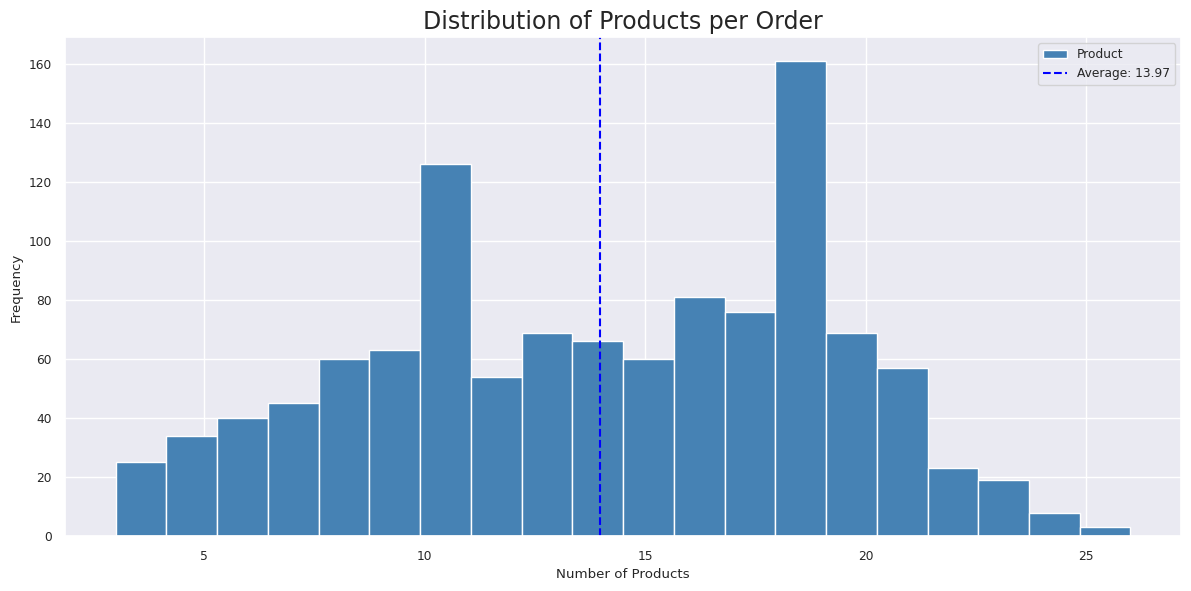

In [16]:
# Visualizing the distribution of the number of products per order
products_per_order = df_mba_treated.groupby('Order_id')['Product'].count()

products_per_order.plot(kind='hist', bins=20)
plt.axvline(products_per_order.mean(), color='blue', linestyle='--', label=f'Average: {products_per_order.mean():.2f}')
plt.title('Distribution of Products per Order',fontsize=17)
plt.xlabel('Number of Products')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()

**Order Size Distribution:**

* The average order contains about 14 products, indicating customers typically make moderate-sized purchases.
* Most orders include 10 to 18 products, suggesting a balanced mix of shopping patterns.

### Bivariate Analysis

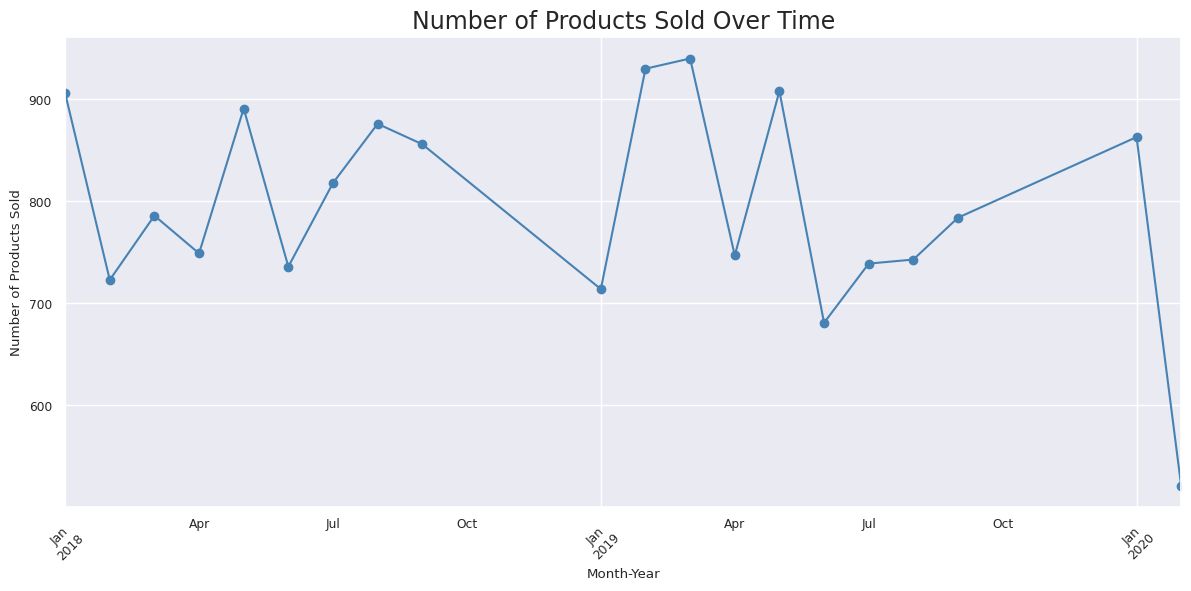

In [17]:
from re import M
# Visualizing the number of products sold over time
monthly_sales = df_mba_treated.groupby(df_mba_treated['Order_date'].dt.to_period('M'))['Product'].count()

monthly_sales.plot(kind='line', marker='o')
plt.title('Number of Products Sold Over Time', fontsize=17)
plt.xlabel('Month-Year')
plt.ylabel('Number of Products Sold')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


**Date vs. Number of Products Sold:**

* Product sales align with transaction trends, peaking during certain months, likely due to promotions or holidays.
* Consistent sales with periodic spikes indicate regular purchasing behavior with occasional influences from external events.

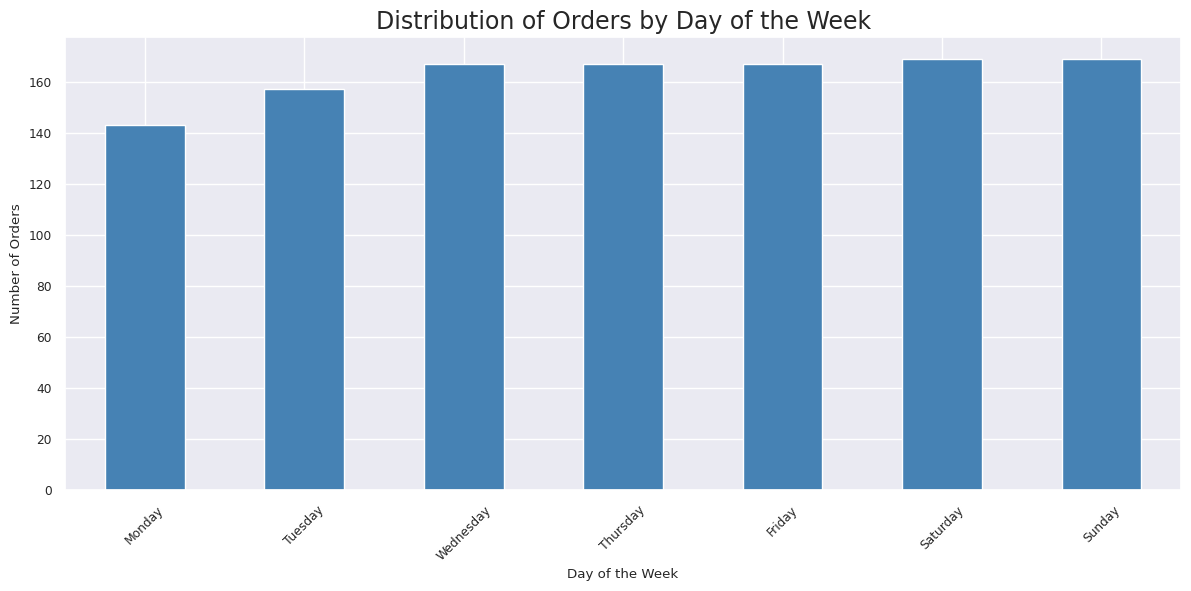

In [18]:
# Visualizing the distribution of orders by day of the week
df_mba_treated['Day_of_Week'] = df_mba_treated['Order_date'].dt.day_name()
orders_by_day = df_mba_treated.groupby('Day_of_Week')['Order_id'].nunique().reindex(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

orders_by_day.plot(kind='bar')
plt.title('Distribution of Orders by Day of the Week', fontsize=17)
plt.xlabel('Day of the Week')
plt.ylabel('Number of Orders')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Day of the Week vs. Number of Transactions:**

* Transactions peak on weekends, particularly Saturdays, reflecting a preference for shopping during weekends.
* Mondays have the lowest transaction volume, possibly due to customers stocking up over the weekend.

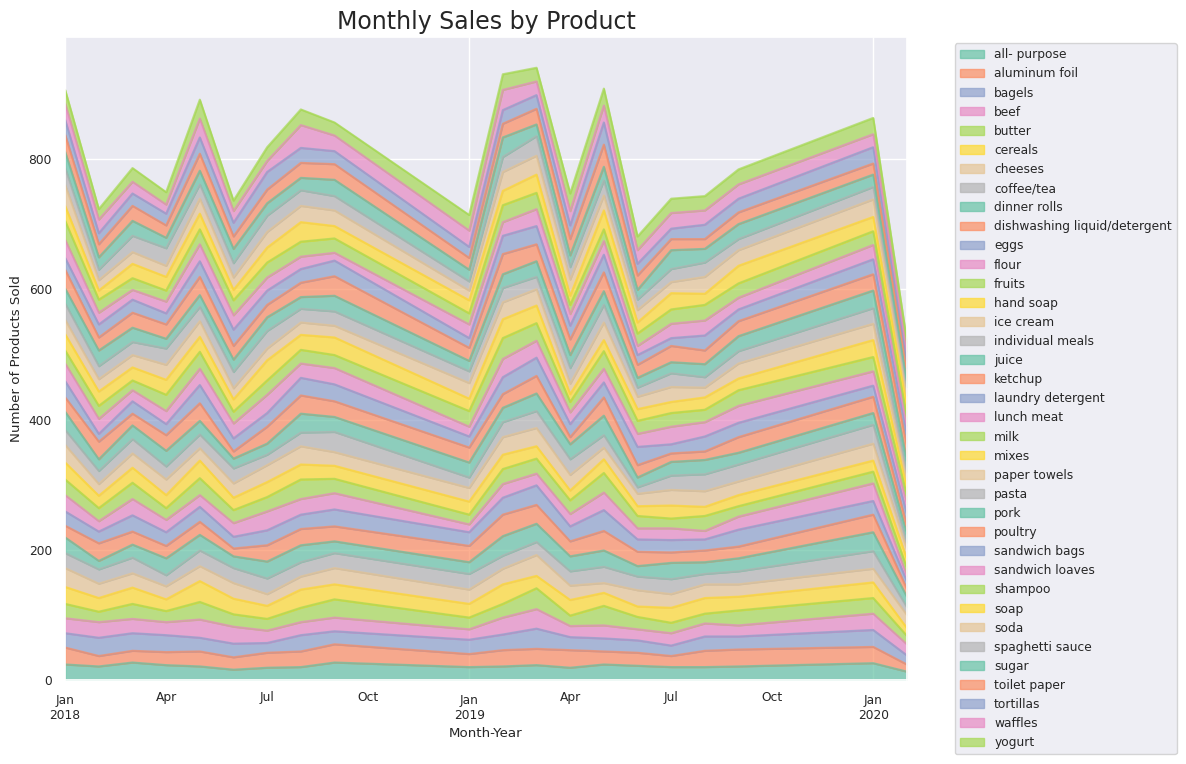

In [19]:
# Visualizing monthly sales by product

# Creating the Month_Year column by extracting month and year from Order_date
df_mba_treated['Month_Year'] = df_mba_treated['Order_date'].dt.to_period('M')
monthly_sales_by_product = df_mba_treated.groupby(['Month_Year', 'Product'])['Order_id'].count().unstack().fillna(0)

# Create a color palette similar to blue
palette = sns.color_palette('Set2', n_colors=monthly_sales_by_product.shape[1])

monthly_sales_by_product.plot(kind='area', stacked=True, alpha=0.7, figsize=(12, 8), color=palette)
plt.title('Monthly Sales by Product', fontsize=17)
plt.xlabel('Month-Year')
plt.ylabel('Number of Products Sold')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

**Product vs. Frequency of Purchase:**

* Poultry and other top products maintain high sales across all months, indicating stable demand.
* Some products exhibit seasonal variability, suggesting targeted opportunities for promotions.

### Time-Series Analysis:

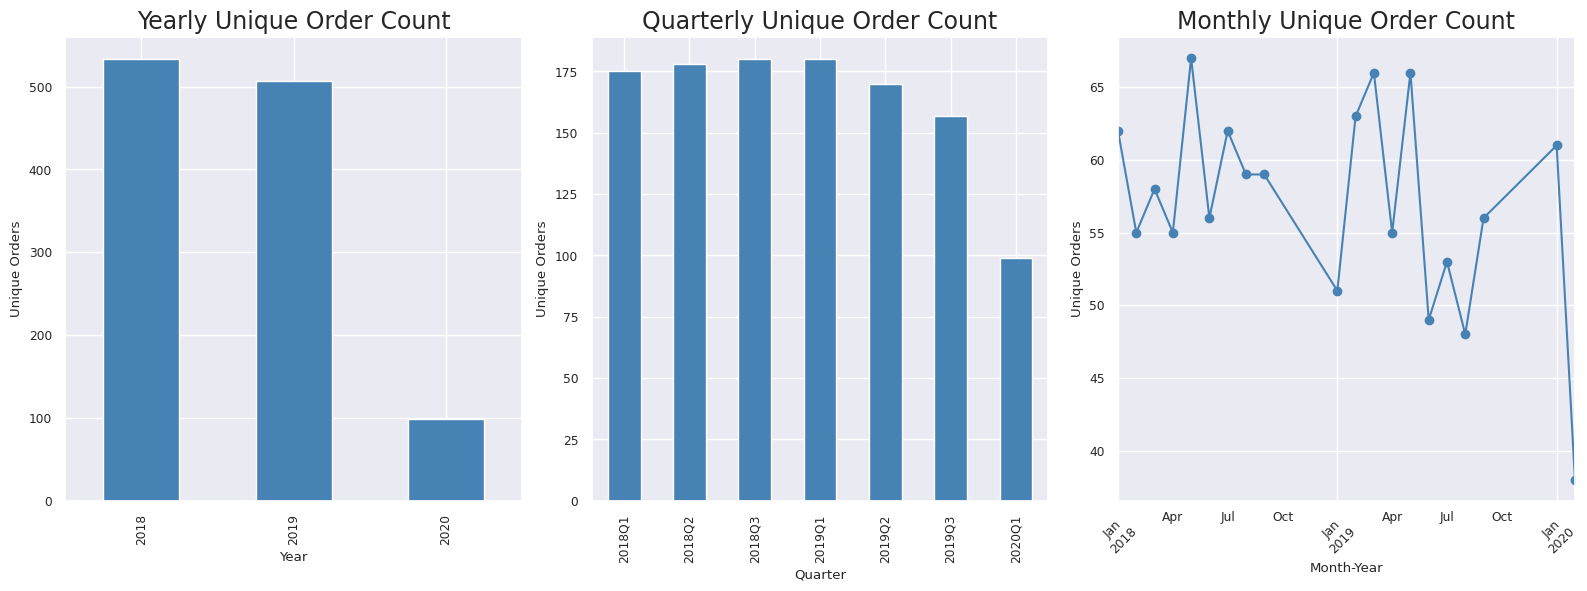

In [20]:
# Grouping the data by year, quarter, and month to calculate the unique order counts

# Yearly Unique Order Count
yearly_orders = df_mba_treated.groupby(df_mba_treated['Order_date'].dt.year)['Order_id'].nunique()

# Quarterly Unique Order Count
quarterly_orders = df_mba_treated.groupby(df_mba_treated['Order_date'].dt.to_period('Q'))['Order_id'].nunique()

# Monthly Unique Order Count
monthly_orders = df_mba_treated.groupby(df_mba_treated['Order_date'].dt.to_period('M'))['Order_id'].nunique()

# Plotting the results
# Yearly Orders

plt.subplot(1, 3, 1)
yearly_orders.plot(kind='bar', figsize=(16, 6))
plt.title('Yearly Unique Order Count', fontsize=17)
plt.xlabel('Year')
plt.ylabel('Unique Orders')
plt.grid(True)

# Quarterly Orders
plt.subplot(1, 3, 2)
quarterly_orders.plot(kind='bar', figsize=(16, 6))
plt.title('Quarterly Unique Order Count', fontsize=17)
plt.xlabel('Quarter')
plt.ylabel('Unique Orders')
plt.grid(True)

# Monthly Orders
plt.subplot(1, 3, 3)
monthly_orders.plot(kind='line', marker='o', figsize=(16, 6))
plt.title('Monthly Unique Order Count', fontsize=17)
plt.xlabel('Month-Year')
plt.ylabel('Unique Orders')
plt.grid(True)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

**Yearly Trends:**

* There is a significant increase in unique orders from 2018 to 2020, indicating growing customer engagement or effective business expansion strategies.

**Quarterly Trends:**

* Unique orders peak during the last quarter each year, particularly around the holiday season, suggesting strong seasonal shopping behavior.
Mid-year quarters (Q2 and Q3) generally see lower order volumes, possibly reflecting a dip in customer activity during these periods.

**Monthly Trends:**

* Monthly order counts fluctuate, with clear peaks in November and December, aligning with holiday shopping trends.
* An overall upward trend in monthly orders indicates increasing customer participation over time, possibly due to successful marketing or increased brand loyalty.

### EDA Summary and Key Findings:

**Transaction Trends:**
* **Yearly/Month Growth:** Significant increase in unique orders from 2018 to 2020, with peaks in Mid and End year, indicating strong seasonal shopping.

**Product Popularity:**
* **Top Products:** "Poultry," "ice cream," and "cereals" dominate sales, important as staple items.
* **Consistent Demand:** Top products maintain steady sales throughout the year, crucial for inventory and marketing focus.

**Order Size Distribution:**
* **Moderate Purchases:** Most orders contain 10-18 products, with an average of 14 items per order, reflecting typical shopping habits.

**Customer Shopping Patterns:**
* **Weekend Preference:** Higher transactions on weekends, with a dip on Mondays, suggesting weekend shopping is preferred.
* **Seasonal Peaks:** Increased sales during holiday seasons, pointing to strong seasonal demand.

**Duplicate Removal:**

The dataset initially contained 4,730 duplicate records, which were removed to ensure the accuracy of the analysis.

**Conclusion:**

The analysis highlights consistent demand for key products and clear seasonal shopping patterns. These insights can guide targeted promotions, efficient inventory management, and strategic planning to enhance store performance

